In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
import random
import os
import sys
from collections import deque
import pygame

In [5]:
class Actor(tf.keras.Model):
    def __init__(self, action_dim, action_bound):
        super(Actor, self).__init__()
        self.action_bound = action_bound
        self.fc1 = Dense(64, activation='relu')
        self.fc2 = Dense(64, activation='relu')
        self.fc3 = Dense(action_dim, activation='tanh')  # -2.0 ~ 2.0 사이의 액션 값 반환

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        a = self.fc3(x)
        a = Lambda(lambda x: x*self.action_bound)(a)
        return a

class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = Dense(64, activation='relu')
        self.fc2 = Dense(64, activation='relu')
        self.fc3 = Dense(1, activation='linear')

    def call(self, state, action):
        x = tf.concat([state, action], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
        
        
        

In [6]:
class Agent():
    def __init__(self, state_size, action_size):
        self.render = False
        self.state_size = state_size
        self.action_size = action_size
        self.action_bound = env.action_space.high[0]
        self.actor = Actor(action_size, self.action_bound)
        self.target_actor = Actor(action_size, self.action_bound)
        self.critic = Critic()
        self.target_critic = Critic()
        self.actor_optimizer = Adam(learning_rate=0.001)
        self.critic_optimizer = Adam(learning_rate=0.001)
        self.train_start = 1000
        self.gamma = 0.99
        self.tau = 0.001
        self.memory = deque(maxlen=2000)
        self.batch_size = 64
        
        
    def get_action(self, state):
        action = self.actor(state)[0][0]
        return action
        
    def append_sample(self, state, action, reward, next_state, done):
        # print(state)
        self.memory.append((state, action, reward, next_state, done))
    
    def ou_noise(self, x, rho=0.15, mu=0, dt=1e-1, sigma=0.2, dim=1):
        return x + rho*(mu - x)*dt + sigma*np.sqrt(dt)*np.random.normal(size=dim)
    
    def train_model(self):
        
        mini_batch = random.sample(self.memory, self.batch_size)
        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])
        actions = np.reshape(actions, [-1, 1])
        next_actions = self.target_actor(next_states)
        next_actions = np.reshape(next_actions, [-1, 1])
        q_values = self.target_critic(next_states, next_actions)
        targets = rewards + self.gamma * q_values * (1 - dones)

        with tf.GradientTape() as tape:
            q_values = self.critic(states, actions)
            critic_loss = tf.reduce_mean(tf.square(q_values - targets))

        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            actions = self.actor(states)
            q_values = self.critic(states, actions)
            actor_loss = -tf.reduce_mean(q_values)

        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))

        self.update_target_networks(self.tau)
        
    def update_target_networks(self, tau):
        actor_weights = self.actor.get_weights()
        target_actor_weights = self.target_actor.get_weights()
        critic_weights = self.critic.get_weights()
        target_critic_weights = self.target_critic.get_weights()

        for i in range(len(actor_weights)):
            target_actor_weights[i] = tau * actor_weights[i] + (1 - tau) * target_actor_weights[i]

        for i in range(len(critic_weights)):
            target_critic_weights[i] = tau * critic_weights[i] + (1 - tau) * target_critic_weights[i]

        self.target_actor.set_weights(target_actor_weights)
        self.target_critic.set_weights(target_critic_weights)
        
if __name__ == "__main__":
    env = gym.make('Pendulum-v1', g = 10)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    
    agent = Agent(state_size, action_size)
    
    scores, episodes = [], []
    score_avg = 0
    
    num_episode = 1000
    agent.update_target_networks(1.0)
    for e in range(num_episode):
        done= False
        score = 0
        state = env.reset()[0]
        state = np.array([state])
        pre_noise = np.zeros(action_size)
        
        
        
        while not done:
            if agent.render==True and e % 10 == 0:
                env.render()
                
            action = agent.get_action(state)
            noise = agent.ou_noise(pre_noise, dim=action_size)
            action = np.clip(action + noise, -2, 2)
            next_state, reward, _, done, _ = env.step((action,))
            
            next_state = np.reshape(next_state, [1, state_size])
            
            score += reward[0]
            # print(state)
            agent.append_sample(state, action, reward, next_state, done)
            if len(agent.memory) >= agent.train_start:
                agent.train_model()
                
            state = next_state
            
            if done:
                pre_noise = noise
                scores.append(score)
                episodes.append(e)
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {:3d} | score {:3.2f} | score avg {:3.2f} | memory length: {:4d}".format(
                    e, score, score_avg, len(agent.memory)))


                
                if score_avg > -300:
                    #save model
                    agent.actor.save_weights("./save_model/model", save_format="tf")
                    sys.exit()
                    
            
       

c:\Users\layen\anaconda3\envs\cuda\lib\site-packages\gymnasium\utils\passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\layen\anaconda3\envs\cuda\lib\site-packages\gymnasium\utils\passive_env_checker.py:276: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  f"The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: {type(reward)}"


episode:   0 | score -1631.87 | score avg -1631.87 | memory length:  200
episode:   1 | score -1684.58 | score avg -1637.14 | memory length:  400
episode:   2 | score -1848.57 | score avg -1658.28 | memory length:  600
episode:   3 | score -1546.97 | score avg -1647.15 | memory length:  800
episode:   4 | score -1760.46 | score avg -1658.48 | memory length: 1000
episode:   5 | score -1560.05 | score avg -1648.64 | memory length: 1200
episode:   6 | score -1624.27 | score avg -1646.20 | memory length: 1400
episode:   7 | score -1674.29 | score avg -1649.01 | memory length: 1600
episode:   8 | score -1628.50 | score avg -1646.96 | memory length: 1800
episode:   9 | score -1443.04 | score avg -1626.57 | memory length: 2000
episode:  10 | score -1658.35 | score avg -1629.75 | memory length: 2000
episode:  11 | score -1706.62 | score avg -1637.43 | memory length: 2000
episode:  12 | score -1548.02 | score avg -1628.49 | memory length: 2000
episode:  13 | score -1611.81 | score avg -1626.82 

SystemExit: 

c:\Users\layen\anaconda3\envs\cuda\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


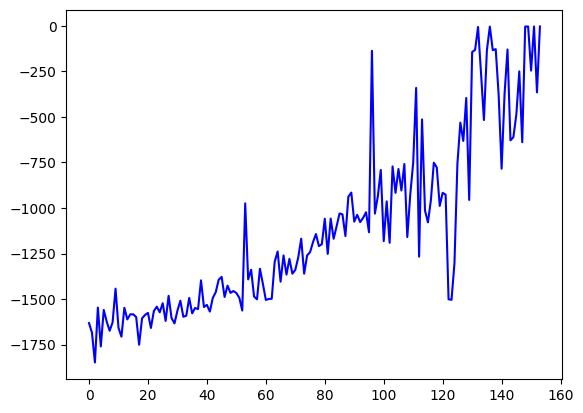

episode:   0 | score: -3.622342
episode:   1 | score: -129.400046
episode:   2 | score: -251.385197
episode:   3 | score: -2.776450
episode:   4 | score: -2.522014


In [9]:
# play saved model
agent.actor.load_weights("./save_model/model")
agent.epsilon = 0.01
env = gym.make('Pendulum-v1', g = 10, render_mode = 'human')
plt.plot(episodes, scores, 'b')
plt.show()

for e in range(5):
    
    done = False
    score = 0
    state = env.reset()[0]
    state = np.array([state])
    
    while not done:
        env.render()
        action = agent.get_action(state)
        next_state, reward, _, done, _ = env.step((action,))
        next_state = np.reshape(next_state, [1, state_size])
                
        score += reward
        state = next_state
        if done:
            print("episode: {:3d} | score: {:3f}".format(e, score))
pygame.quit()
env.close()